In [1]:
using Revise

## Overview

- We need to show "preliminary results" for 11th may.

- Then we will have another 2-3 weeks to work on the final results.

- Results for last year's benchmarks -- but run with the current versions of the packages (see below) -- are done:

    - [Van der Pol benchmark](https://github.com/mforets/escritoire/blob/master/2020/Week16/VanDerPol_ARCH-COMP2020.ipynb)
    - [Laub-loomis benchmark](https://github.com/mforets/escritoire/blob/master/2020/Week16/Laub-Loomis_ARCH-COMP2020.ipynb)
    - [Quadrotor benchmark](https://github.com/mforets/escritoire/blob/master/2020/Week16/Quadrotor_ARCH-COMP2020.ipynb)

- Among these, two models have been extended this year:

    - [Quadrotor with larger initial sets](https://github.com/mforets/escritoire/blob/master/2020/Week19/Quadrotor_ARCH-COMP2020_new.ipynb).
        - Seems to work quite well.

    - [Coupled der Pol oscillator](https://github.com/mforets/escritoire/blob/master/2020/Week18/CoupledVanDerPol2.ipynb)
        - The hardest scenario is the stiff $\mu = 2$ case. We were able to validate that $y \leq \beta$ is safe for $\beta \geq 4.05$. However, it remains to see if we can prove smaller $\beta$ and if there is a better choice of the partition of the initial sets, or another strategy, such as partitionining in the intermediate computations and recomputing from that point.

- Last year we were not able to handle the hybrid model (Space rendez-vous) This is one of the goals of this year. Moreover, this year this model is extended for non-deterministic time guards.

- Finally, there are two new models this year:

    - Production-destruction system (Michaelis-Menten).
    - Lotka-Volterra with a tangential crossing.

- There is a [Trello board with some open tasks](https://trello.com/b/QQEIjTmW/arch-comp2020-nln).

## Workflow

- New package [ReachabilityAnalysis.jl](https://github.com/JuliaReach/ReachabilityAnalysis.jl).
    - Defines a common `solve` interface to solve reachability problems, for purely continuous (linear and nonlinear) and for hybrid systems.
    - Inspired by the `DifferentialEquations.jl` user interface.
    - It is already registered in the general registry. However it's still under heavy development :)
    - [Documentation is in progress](https://juliareach.github.io/ReachabilityAnalysis.jl/dev/introduction/#Introduction-1).
    - We plan to add a library of example models (`ReachabilityModels.jl`) using Literate.jl to exhibit both documentation style and executable jupyter notebooks on the cloud.
    - A library of reachability benchmarks (`ReachabilityBenchmarks`) exists and we have used it for previous papers, however, we still need to adapt it to the new `ReachabiliyAnalis.jl` interface.

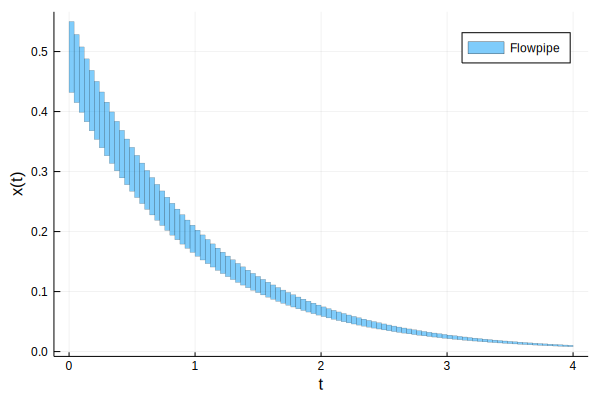

In [47]:
using ReachabilityAnalysis, Plots

# define the initial-value problem
# x' = Ax + Bu, x ∈ X, u ∈ U, x(0) ∈ X0
prob = @ivp(x' = -x, x(0) ∈ 0.45 .. 0.55)

# solve it
sol = solve(prob, T=4.0)

# plot the solution, where the index 0 corresponds to the "time" variable
plot(sol, vars=(0, 1), label="Flowpipe", xlab="t", ylab="x(t)", linewidth=0.3)

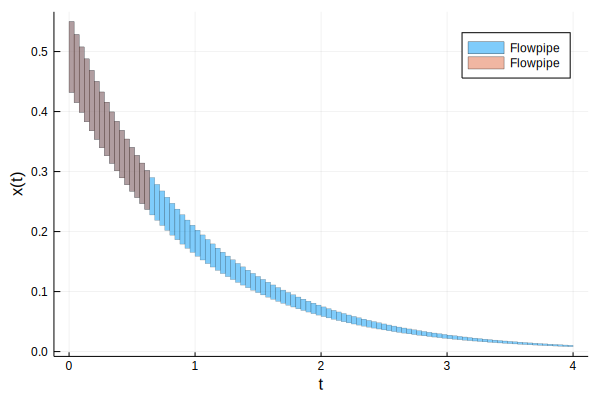

In [48]:
using ReachabilityAnalysis, Plots

# define the initial-value problem
# x' = Ax + Bu, x ∈ X, u ∈ U, x(0) ∈ X0
# x >= 0.3
prob = @ivp(x' = -x, x(0) ∈ 0.45 .. 0.55, x ∈ HalfSpace([-1.0], -0.3))

# solve it
sol = solve(prob, T=4.0)

# plot the solution, where the index 0 corresponds to the "time" variable
plot!(sol, vars=(0, 1), label="Flowpipe", xlab="t", ylab="x(t)", linewidth=0.3)

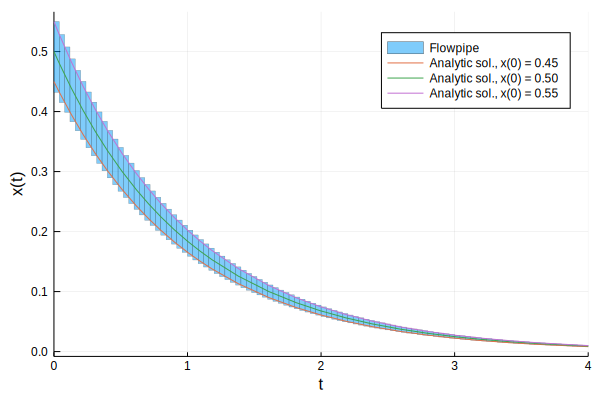

In [3]:
f(t, x0) = x0 * exp(-t)

plot!(t -> f(t, 0.45), xlims=(0, 4), label="Analytic sol., x(0) = 0.45")
plot!(t -> f(t, 0.50), xlims=(0, 4), label="Analytic sol., x(0) = 0.50")
plot!(t -> f(t, 0.55), xlims=(0, 4), label="Analytic sol., x(0) = 0.55")

- `ReachabilityAnalysis.jl` implements algorithms for:

   - Computing flowpipes for $x' = Ax + Bu$ with $x(0) \in X_0$ and $u \in U$ with $X_0$ and $U$ sets given by their support function, using state-of-the art methods (wrapping free, combination of zonotopes and support functions). Algorithms: `GLGM06`, `LGG09`, `BOX`, `INT`.
   - $x' = Ax + Bu$ where $A$ and $B$ are interval matrices using zonotopes, so the problem is still *linear*. Algorithm: `ASB07`.
   - Working on porting the hybrid systems stuff from the previous `Reachability.jl` package (https://arxiv.org/abs/1901.10736).
   - Flowpipes of nonlinear systems `x' = f(x, u, p, t)`. Algorithms `TMJets`. This works with `TaylorModels.validated_integ`, by converting the given initial states (often given as a LazySet) to an `IntervalArithmetic.IntervalBox`.

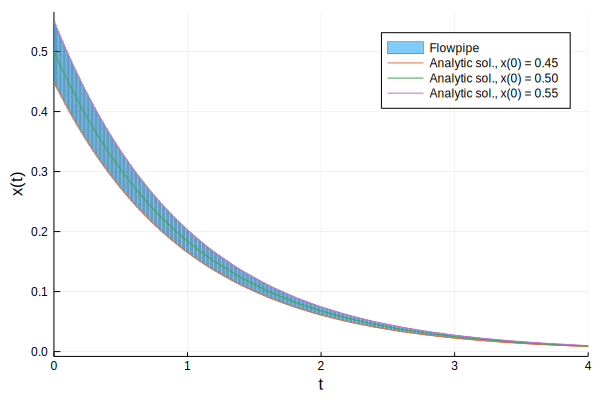

In [4]:
# change the step size
sol = solve(prob, T=4.0, alg=INT(δ=0.01))

# plot the solution, where the index 0 corresponds to the "time" variable
plot(sol, vars=(0, 1), label="Flowpipe", xlab="t", ylab="x(t)", linewidth=0.3)

f(t, x0) = x0 * exp(-t)

plot!(t -> f(t, 0.45), xlims=(0, 4), label="Analytic sol., x(0) = 0.45")
plot!(t -> f(t, 0.50), xlims=(0, 4), label="Analytic sol., x(0) = 0.50")
plot!(t -> f(t, 0.55), xlims=(0, 4), label="Analytic sol., x(0) = 0.55")

In [5]:
using BenchmarkTools

In [6]:
@btime solve($prob, T=4.0, alg=INT(δ=0.01));

  22.764 μs (29 allocations: 14.61 KiB)


Using `TMJets` algorithm:

In [19]:
@taylorize function exponential_decay!(dx, x, p, t)
    dx[1] = -x[1]
end

prob = @ivp(x'= exponential_decay!(x), dim:1, x(0) ∈ Interval(0.45, 0.55))

solTM = solve(prob, T=4.0);

In [25]:
solTM[2]

TaylorModelReachSet{Float64}(TaylorModels.TaylorModel1{TaylorN{Float64},Float64}[  0.5 + 0.050000000000000044 x₁ + ( - 0.5 - 0.050000000000000044 x₁) t + ( 0.25 + 0.025000000000000022 x₁) t² + ( - 0.08333333333333333 - 0.00833333333333334 x₁) t³ + ( 0.020833333333333332 + 0.002083333333333335 x₁) t⁴ + ( - 0.004166666666666667 - 0.000416666666666667 x₁) t⁵ + ( 0.0006944444444444444 + 6.94444444444445e-5 x₁) t⁶ + ( - 9.920634920634919e-5 - 9.920634920634927e-6 x₁) t⁷ + ( 1.2400793650793649e-5 + 1.240079365079366e-6 x₁) t⁸ + [-2.99281e-18, 1.4909e-18]], [0.0268575, 0.0538183])

In [26]:
tspan(solTM[2])

[0.0268575, 0.0538183]

In [27]:
set(solTM[2])

1-element Array{TaylorModels.TaylorModel1{TaylorN{Float64},Float64},1}:
   0.5 + 0.050000000000000044 x₁ + ( - 0.5 - 0.050000000000000044 x₁) t + ( 0.25 + 0.025000000000000022 x₁) t² + ( - 0.08333333333333333 - 0.00833333333333334 x₁) t³ + ( 0.020833333333333332 + 0.002083333333333335 x₁) t⁴ + ( - 0.004166666666666667 - 0.000416666666666667 x₁) t⁵ + ( 0.0006944444444444444 + 6.94444444444445e-5 x₁) t⁶ + ( - 9.920634920634919e-5 - 9.920634920634927e-6 x₁) t⁷ + ( 1.2400793650793649e-5 + 1.240079365079366e-6 x₁) t⁸ + [-2.99281e-18, 1.4909e-18]

In [28]:
solTM(0 .. 0.5)

19-element view(::Array{TaylorModelReachSet{Float64},1}, 1:19) with eltype TaylorModelReachSet{Float64}:
 TaylorModelReachSet{Float64}(TaylorModels.TaylorModel1{TaylorN{Float64},Float64}[  0.5 + 0.050000000000000044 x₁ + [0, 0]], [0, 0.0268576])
 TaylorModelReachSet{Float64}(TaylorModels.TaylorModel1{TaylorN{Float64},Float64}[  0.5 + 0.050000000000000044 x₁ + ( - 0.5 - 0.050000000000000044 x₁) t + ( 0.25 + 0.025000000000000022 x₁) t² + ( - 0.08333333333333333 - 0.00833333333333334 x₁) t³ + ( 0.020833333333333332 + 0.002083333333333335 x₁) t⁴ + ( - 0.004166666666666667 - 0.000416666666666667 x₁) t⁵ + ( 0.0006944444444444444 + 6.94444444444445e-5 x₁) t⁶ + ( - 9.920634920634919e-5 - 9.920634920634927e-6 x₁) t⁷ + ( 1.2400793650793649e-5 + 1.240079365079366e-6 x₁) t⁸ + [-2.99281e-18, 1.4909e-18]], [0.0268575, 0.0538183])
 TaylorModelReachSet{Float64}(TaylorModels.TaylorModel1{TaylorN{Float64},Float64}[  0.4867499714943714 + 0.04867499714943718 x₁ + ( - 0.4867499714943714 - 0.048674997149437

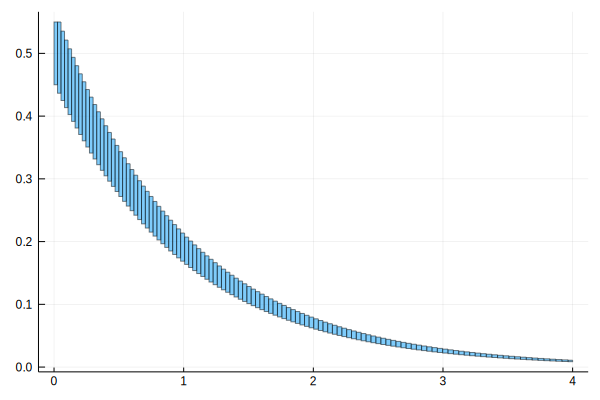

In [20]:
plot(overapproximate(solTM, Zonotope), vars=(0, 1))

In [21]:
@btime solve($prob, T=4.0, alg=TMJets());

  83.911 ms (1645930 allocations: 96.26 MiB)


## New features in ReachabilityAnalysis

- Flowpipes have array-like interface and evaluation-like interface to evaluate at time points or at time intervals. 

In [10]:
typeof(sol)

ReachabilityAnalysis.ReachSolution{Flowpipe{Float64,ReachSet{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}}},Array{ReachSet{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}}},1}},INT{Float64,Forward{Val{:base},Val{:interval},Val{:concrete}}}}

In [11]:
sol[1]

ReachSet{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.445495, 0.550001]), [0, 0.0100001])

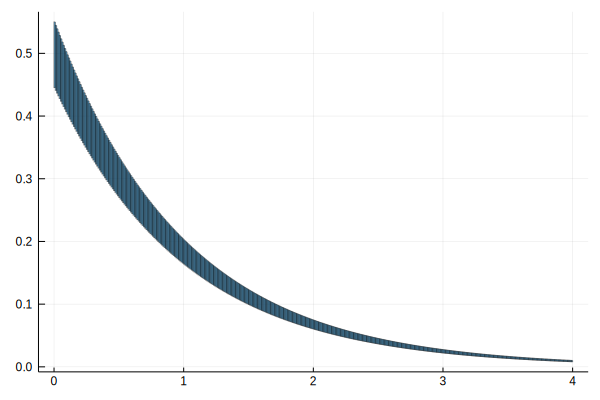

In [12]:
plot(sol, vars=(0, 1))

In [13]:
using BenchmarkTools

In [14]:
@btime solve()

MethodError: MethodError: no method matching solve()
Closest candidates are:
  solve(!Matched::InitialValueProblem{AT,VT}, !Matched::Any...; kwargs...) where {AT<:AbstractContinuousSystem, ST<:LazySet, VT<:AbstractArray{ST,1}} at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Continuous/solve.jl:80
  solve(!Matched::InitialValueProblem{#s229,XT} where XT where #s229<:HACLD1, !Matched::Any...; kwargs...) at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Hybrid/time_triggered.jl:181
  solve(!Matched::InitialValueProblem, !Matched::Any...; kwargs...) at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Continuous/solve.jl:49

- Conversion of *Taylor model flowpipes* to zonotopes for property verification and hybrid systems.

- Interface to split initial sets. Uses multithreading.

```julia
# start from sets X01 and X02
prob = @ivp(x' = f(x), x(0) ∈ [X01, X02])

# split the hyperrectangular set X0 into 12 equal boxes, with 2 cuts over direction
# x and 6 cuts over direction y
prob = @ivp(x' = f(x), x(0) ∈ split(X0, [2, 6]))
```

In [30]:
@taylorize function exponential_decay!(dx, x, p, t)
    dx[1] = -x[1]
end

X01 = Interval(0.45, 5.0)
X02 = Interval(0.5, 5.5)
prob = @ivp(x'= exponential_decay!(x), dim:1, x(0) ∈ [X01,X02])

solTM = solve(prob, T=4.0);

In [31]:

@taylorize function vdp!(dx, x, params, t)
    local μ = 1.0
    dx[1] = x[2]
    dx[2] = (μ * x[2]) * (1 - x[1]^2) - x[1]
    return dx
end

In [32]:
X0 = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45]) # initial condition
prob = @ivp(x' = vdp!(x), dim=2, x(0) ∈ X0) # initial-value problem
T = 7.0; # time horizon

In [33]:
sol = solve(prob, T=T, alg=TMJets(abs_tol=1e-10, orderT=10, orderQ=2));


In [34]:
solz = overapproximate(sol, Zonotope);

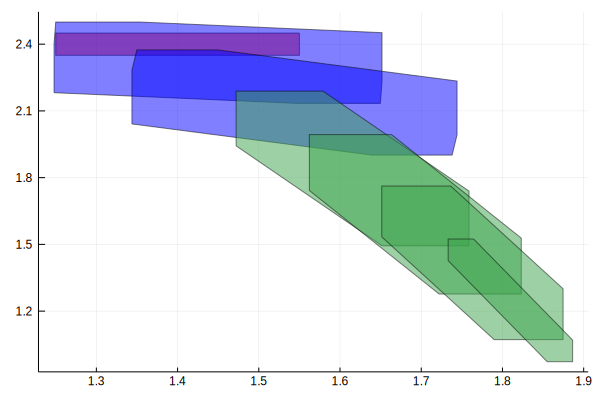

In [42]:
plot(solz[1], vars=(1, 2), color=:red)
plot!(solz[2:3], vars=(1, 2), color=:blue)
plot!(solz[end-3:end], vars=(1, 2))

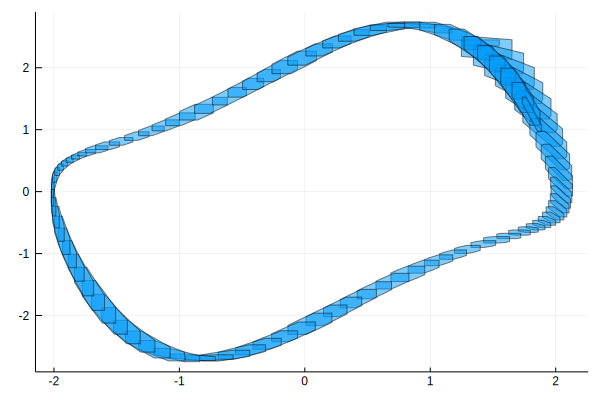

In [35]:
plot(solz, vars=(1, 2))

## Hybrid systems ..